# Importing , Training & Saving the Pre-Trained Model

## Installing Libraries

In [1]:
%pip install transformers
%pip install -q datasets transformers
%pip install huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 25.1 MB/s 
     |████████████████████████████████| 7.6 MB 43.2 MB/s 
     |████████████████████████████████| 182 kB 72.3 MB/s 
     |████████████████████████████████| 451 kB 21.2 MB/s 
     |████████████████████████████████| 132 kB 64.6 MB/s 
     |████████████████████████████████| 212 kB 61.5 MB/s 
     |████████████████████████████████| 127 kB 14.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importing Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from huggingface_hub import notebook_login
from transformers import AutoFeatureExtractor, AutoModelForImageClassification, DefaultDataCollator , TrainingArguments, Trainer
from google.colab import drive
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor
from datasets import load_metric, load_dataset
import os

## Loading fashion-minst Dataset

In [3]:
dataset = load_dataset("fashion_mnist")
dataset

Extracting data files #2:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #3:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [4]:
dataset["train"][2]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x7FD77250A160>,
 'label': 0}

In [5]:
dataset["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

In [6]:
dataset["train"][2]['image']

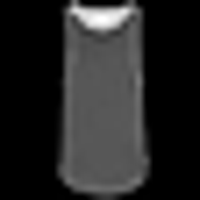

In [7]:
dataset["train"][2]['image'].resize((200, 200))

In [8]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[2]

'Pullover'

## Load Metric

In [9]:
#loading the metrics accuracy
metric = load_metric("accuracy")

<ipython-input-9-45472ef377a3>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


## Loading Feature Extractor

In [10]:
extractor = AutoFeatureExtractor.from_pretrained("microsoft/swin-base-patch4-window7-224-in22k")
extractor

Downloading:   0%|          | 0.00/255 [00:00<?, ?B/s]

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

## Pre-Processing 

In [11]:
#normalizing the images
normalize = Normalize(mean=extractor.image_mean, std=extractor.image_std)
_transforms = Compose([RandomResizedCrop((224,224)), ToTensor(), normalize])

In [12]:
def transforms(data):
    data["pixel_values"] = [_transforms(img.convert("RGB")) for img in data["image"]]
    del data["image"]
    return data

In [13]:
dataset = dataset.with_transform(transforms)

In [14]:
dataset['train'][2]

{'label': 0,
 'pixel_values': tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],

In [15]:
data_collator = DefaultDataCollator()

In [16]:
dataset['train'][2]

{'label': 0,
 'pixel_values': tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],

## Evaluate

In [17]:
predictions = 0
real_labels = 0

In [18]:
#In this compute_metrics function,Tuple is taken as input ,predictions are model logits ,label_ids are lables representings the classes
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    global predictions
    global real_labels
    predictions = np.argmax(eval_pred.predictions, axis=1)
    real_labels = eval_pred.label_ids
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)




## Training the Model

In [19]:
#model and batch size is inialized
model_checkpoint='microsoft/swin-base-patch4-window7-224-in22k'
batch_size = 32 

In [20]:
#pixel values and labels are keys used in each Batch, DATA_COLLATOR is used to batch these data instances together.
model = AutoModelForImageClassification.from_pretrained(
    "microsoft/swin-base-patch4-window7-224-in22k",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes = True,
)

Downloading:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/437M [00:00<?, ?B/s]

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224-in22k and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([21841, 1024]) in the checkpoint and torch.Size([10, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([21841]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
#training arguments given and 10 epochs mentioned with a batch size of 32
training_args = TrainingArguments(
    output_dir="./results",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

In [22]:
#All the arguents passedto trainer with model name
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=extractor,
    compute_metrics=compute_metrics
)


In [ ]:
#Model is saved after each epoch as checkpoint
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 60000
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 4680
  Number of trainable parameters = 86753474


Epoch,Training Loss,Validation Loss,Accuracy
0,0.420100,0.469324,0.830600
1,0.353100,0.359955,0.868400
2,0.305800,0.381484,0.869000
3,0.281900,0.321736,0.885200
4,0.279900,0.291776,0.894500
5,0.280400,0.286269,0.898300
6,0.235000,0.288660,0.895400
7,0.268400,0.284746,0.896500
8,0.227600,0.263593,0.907200
9,0.204000,0.258871,0.908600


***** Running Evaluation *****
  Num examples = 10000
  Batch size = 32
Saving model checkpoint to ./results/checkpoint-468
Configuration saved in ./results/checkpoint-468/config.json
Model weights saved in ./results/checkpoint-468/pytorch_model.bin
Image processor saved in ./results/checkpoint-468/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 10000
  Batch size = 32
Saving model checkpoint to ./results/checkpoint-936
Configuration saved in ./results/checkpoint-936/config.json
Model weights saved in ./results/checkpoint-936/pytorch_model.bin
Image processor saved in ./results/checkpoint-936/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 10000
  Batch size = 32
Saving model checkpoint to ./results/checkpoint-1404
Configuration saved in ./results/checkpoint-1404/config.json
Model weights saved in ./results/checkpoint-1404/pytorch_model.bin
Image processor saved in ./results/checkpoint-1404/preprocessor_config.json
***** Running Evaluat

***** train metrics *****
  epoch                    =          10.0
  total_flos               = 43776123858GF
  train_loss               =        0.3336
  train_runtime            =    1:58:42.01
  train_samples_per_second =        84.246
  train_steps_per_second   =         0.657


In [23]:
#triner loading the best checkpoint and giving evlaution results
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 10000
  Batch size = 32


***** eval metrics *****
  eval_accuracy           =     0.0495
  eval_loss               =     2.4581
  eval_runtime            = 0:02:11.91
  eval_samples_per_second =     75.808
  eval_steps_per_second   =      2.373


## Evaluation

In [24]:
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score

In [25]:
accuracy , precision, recall, f1 = accuracy_score(real_labels , predictions), precision_score(real_labels , predictions, average='macro'), recall_score(real_labels , predictions, average='macro'), f1_score(real_labels , predictions, average='macro')

In [26]:
"Accuracy : {}, Precision : {}, Recall : {}, F1 score : {}".format(accuracy , precision, recall, f1)

'Accuracy : 0.0495, Precision : 0.061843607983946836, Recall : 0.0495, F1 score : 0.04257014382278882'

## Save the Trained Model

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/Model

/content/drive/MyDrive/Colab Notebooks/Model


In [ ]:
trainer.save_model("model0")

Saving model checkpoint to model0
Configuration saved in model0/config.json
Model weights saved in model0/pytorch_model.bin
Image processor saved in model0/preprocessor_config.json


###Save Entire Model

In [ ]:
torch.save(model, "./model_full.pt")

### Load Entire Model

In [ ]:
model_full = torch.load("./model_full.pt")
model_full.eval()

## Predict

In [ ]:
dataset1 = load_dataset("fashion_mnist")

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
image = dataset1["train"][1]['image']
encoding = extractor(image.convert("RGB"), return_tensors="pt")
print(encoding.pixel_values.shape)

torch.Size([1, 3, 224, 224])


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
inputs = encoding.to(device)

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
with torch.no_grad():
  outputs = model(**inputs)
  logits = outputs.logits

In [ ]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: T - shirt / top


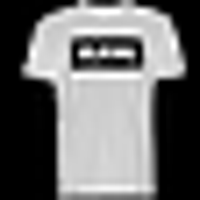

In [ ]:
dataset1["train"][1]['image'].resize((200, 200))

## Push model to huggingface

In [ ]:
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [ ]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [ ]:
trainer.push_to_hub()

# Use Trained Model

## Install Libraries

In [27]:
%pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import the Libraries

In [28]:
from transformers import AutoFeatureExtractor, AutoModelForImageClassification, DefaultDataCollator , TrainingArguments, Trainer
import torch
from datasets import load_metric, load_dataset
from PIL import Image
import requests
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor
import numpy as np
import matplotlib.pyplot as plt

In [29]:
repo_name = "Methmani/Image_Classification_fashion-mnist"


#Model and feature extractor is loaded 
feature_extractor = AutoFeatureExtractor.from_pretrained(repo_name)
trained_model = AutoModelForImageClassification.from_pretrained(repo_name)

Downloading:   0%|          | 0.00/388 [00:00<?, ?B/s]

loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--Methmani--Image_Classification_fashion-mnist/snapshots/c11607facde8405a97adb809607872d65382f79e/preprocessor_config.json
Image processor ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}



Downloading:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--Methmani--Image_Classification_fashion-mnist/snapshots/c11607facde8405a97adb809607872d65382f79e/config.json
Model config SwinConfig {
  "_name_or_path": "Methmani/Image_Classification_fashion-mnist",
  "architectures": [
    "SwinForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    18,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 128,
  "encoder_stride": 32,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "id2label": {
    "0": "T - shirt / top",
    "1": "Trouser",
    "2": "Pullover",
    "3": "Dress",
    "4": "Coat",
    "5": "Sandal",
    "6": "Shirt",
    "7": "Sneaker",
    "8": "Bag",
    "9": "Ankle boot"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "label2id": {
    "Ankle boot": 9,
    "Bag": 8,
    "Coat": 4,
    "Dress": 3,
    "Pullover": 2,
    "Sandal": 5,
    "Shirt": 6,
    "Sneaker": 

Downloading:   0%|          | 0.00/348M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--Methmani--Image_Classification_fashion-mnist/snapshots/c11607facde8405a97adb809607872d65382f79e/pytorch_model.bin
All model checkpoint weights were used when initializing SwinForImageClassification.

All the weights of SwinForImageClassification were initialized from the model checkpoint at Methmani/Image_Classification_fashion-mnist.
If your task is similar to the task the model of the checkpoint was trained on, you can already use SwinForImageClassification for predictions without further training.


## Loading the Dataset

In [30]:
dataset1 = load_dataset("fashion_mnist")

  0%|          | 0/2 [00:00<?, ?it/s]

## Import Image from Dataset to Predict

In [31]:
image = dataset1["test"][55]['image']

## Import Image from a url to Predict

In [ ]:
from PIL import Image
import requests


#image url is given and viewed to predict
url = 'https://cf.shopee.ph/file/c7c54e7cedac3d7ba3941122615a3f78'

image = Image.open(requests.get(url, stream=True).raw)

## View Image

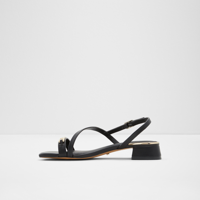

In [ ]:
image.resize((200, 200))

## Transform the Image

In [ ]:
# image is preprocessed using feature extractor
encoding = feature_extractor(image.convert("RGB"), return_tensors="pt")
print(encoding.pixel_values.shape)

torch.Size([1, 3, 224, 224])


## Predict

In [ ]:
#getting the output of the model 
with torch.no_grad():
  outputs = trained_model(**encoding)
  logits = outputs.logits

In [ ]:
#predicting the input with argmax
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", trained_model.config.id2label[predicted_class_idx])

Predicted class: Sandal


## Evaluation

In [32]:
predictions = 0
real_labels = 0

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    global predictions
    global real_labels
    predictions = np.argmax(eval_pred.predictions, axis=1)
    real_labels = eval_pred.label_ids
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_transforms = Compose([RandomResizedCrop((224,224)), ToTensor(), normalize])

def transforms(data):
    data["pixel_values"] = [_transforms(img.convert("RGB")) for img in data["image"]]
    del data["image"]
    return data

dataset2 = dataset1.with_transform(transforms)

model_checkpoint = repo_name
batch_size = 32 
data_collator = DefaultDataCollator()

training_args = TrainingArguments(
    output_dir="./results",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

trainer = Trainer(
    model=trained_model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset2["train"],
    eval_dataset=dataset2["test"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [33]:
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 10000
  Batch size = 32


***** eval metrics *****
  eval_accuracy           =     0.9044
  eval_loss               =     0.2696
  eval_runtime            = 0:02:08.39
  eval_samples_per_second =     77.888
  eval_steps_per_second   =      2.438


### Confusion matrix for testing dataset

In [34]:
confusion_matrix = confusion_matrix(real_labels, predictions)

In [35]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

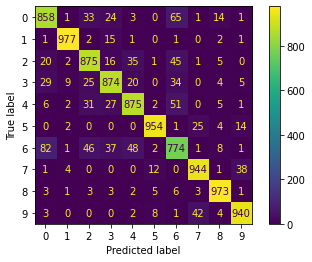

In [36]:
cm_display.plot()
plt.show()

##Evaluate testing dataset

In [37]:
accuracy , precision, recall, f1 = accuracy_score(real_labels , predictions), precision_score(real_labels , predictions, average='macro'), recall_score(real_labels , predictions, average='macro'), f1_score(real_labels , predictions, average='macro')

In [38]:
"Accuracy : {}, Precision : {}, Recall : {}, F1 score : {}".format(accuracy , precision, recall, f1)

'Accuracy : 0.9044, Precision : 0.9041603432493511, Recall : 0.9044000000000001, F1 score : 0.904238285347087'

## Evaluate training dataset

In [39]:
trainer = Trainer(
    model=trained_model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset2["train"],
    eval_dataset=dataset2["train"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics
)

metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

accuracy , precision, recall, f1 = accuracy_score(real_labels , predictions), precision_score(real_labels , predictions, average='macro'), recall_score(real_labels , predictions, average='macro'), f1_score(real_labels , predictions, average='macro')

"Accuracy : {}, Precision : {}, Recall : {}, F1 score : {}".format(accuracy , precision, recall, f1)

***** Running Evaluation *****
  Num examples = 60000
  Batch size = 32


***** eval metrics *****
  eval_accuracy           =     0.9242
  eval_loss               =     0.2041
  eval_runtime            = 0:12:46.79
  eval_samples_per_second =     78.248
  eval_steps_per_second   =      2.445


'Accuracy : 0.9241666666666667, Precision : 0.9240227635771747, Recall : 0.9241666666666667, F1 score : 0.9240600553973459'